In [177]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import hera_pspec as hp
from pyuvdata import UVData
from scipy import stats
from statsmodels.stats import weightstats as stests
from scipy.stats import lognorm, chi2, norm
from scipy.optimize import curve_fit

In [2]:
# Load beam model
beamfile = 'HERA_NF_dipole_power.beamfits'
cosmo = hp.conversions.Cosmo_Conversions()
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

# Load data into UVData objects
dfile = 'zen.2458116.34176.xx.HH.uvOCRS'
uvd = UVData()
uvd.read_miriad(dfile)

In [3]:
# We only have 1 data file here, so slide the time axis by one integration 
# to avoid noise bias (not normally needed!)
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)
ds.rephase_to_dset(0) # Phase to the zeroth dataset

In [4]:
# Specify which baselines to include
baselines = [(66, 67), (83, 84), (82, 120)]

# Define uvp
uvp = ds.pspec(baselines, baselines, (0, 1), [('xx', 'xx')], spw_ranges=[(300, 400), (500, 600)],  input_data_weight='identity',
               norm='I', taper='blackman-harris', verbose=True) 


Setting spectral range: (300, 400)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((66, 67), (66, 67))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((83, 84), (83, 84))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((82, 120), (82, 120))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (500, 600)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((66, 67), (66, 67))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((83, 84), (83, 84))
pol: (-5, -5)

Text(0.5, 1.0, 'spw : 1, blpair : ((66, 67), (66, 67)), pol : xx')

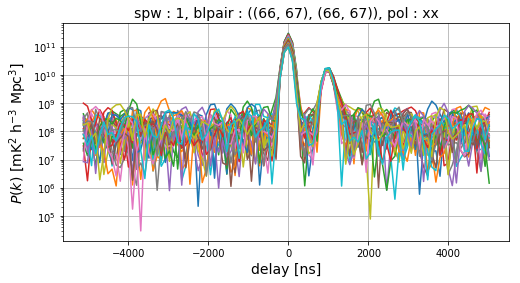

In [82]:
# with cable reflection #1
spw = 1
blp = ((66, 67), (66, 67))
# blp = ((82, 120), (82, 120))
key1 = (spw, blp, 'xx')
dlys = uvp.get_dlys(spw) * 1e9
power1 = np.abs(np.real(uvp.get_data(key1)))

# plot power spectrum of spectral window 1
fig, ax = plt.subplots(figsize=(8,4))
p1 = ax.plot(dlys, power1.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key1), fontsize=14)

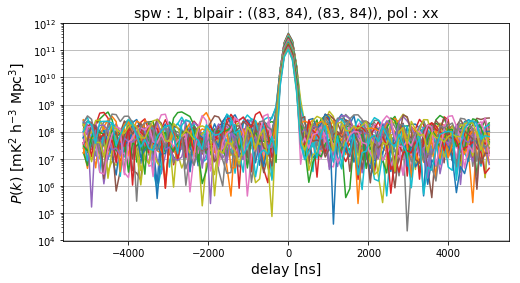

In [83]:
# no cable reflection #1
spw = 1
blp = ((83, 84), (83, 84))
# blp = ((82, 120), (82, 120))
key2 = (spw, blp, 'xx')
dlys = uvp.get_dlys(spw) * 1e9
power2 = np.abs(np.real(uvp.get_data(key2)))

# plot power spectrum of spectral window 1
plt.figure(figsize=(8,4))
plt.semilogy(dlys, power2.T)
plt.grid()
plt.xlabel("delay [ns]", fontsize=14)
plt.ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
plt.title("spw : {}, blpair : {}, pol : {}".format(*key2), fontsize=14)
plt.show()

Text(0.5, 1.0, 'spw : 1, blpair : ((82, 120), (82, 120)), pol : xx')

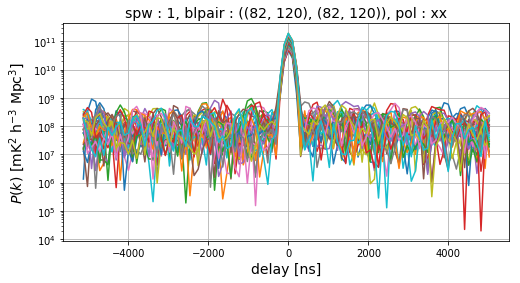

In [84]:
# no cable reflection #2
spw = 1
blp = ((82, 120), (82, 120))
key3 = (spw, blp, 'xx')
dlys = uvp.get_dlys(spw) * 1e9
power3 = np.abs(np.real(uvp.get_data(key3)))

# plot power spectrum of spectral window 1
fig, ax = plt.subplots(figsize=(8,4))
p1 = ax.plot(dlys, power3.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key3), fontsize=14)

In [1]:
# Labels for future plots
def label_z_test():
    plt.hlines(total, x[0], x[-1])
    plt.text(3800, 27,'total', fontsize=12)
    plt.title('Number of groups rejecting H0', fontsize=14)
    plt.xlabel('delay [ns]', fontsize=12)
    plt.ylabel('counts', fontsize=12)
    
def label_null_test_hist():
    plt.title('Null test', fontsize=12)
    plt.ylabel('count', fontsize=12)
    plt.xlabel('difference', fontsize=12)
    
def label_null_test():
    plt.hlines(0, x[0], x[-1])
    plt.title('Null test', fontsize=12)
    plt.ylabel('time', fontsize=12)
    plt.ylabel('difference', fontsize=12)

In [282]:
# Perform two-sample z-test

# Number of groups which rejects H0 (don't have the same mean)
count = {}

power = {0: power1, 1:power2, 2:power3}
key = {0: key1, 1:key2, 3:key3}

# Set delay domain
dly = [-5000, 5000]
# Number of groups going through the test
dly_rg = 200
# Red vertical lines that divides power data into dly_rg groups
lines = []
# Total number of power in one group for one baseline pair
total = 0

for k in range(2):
    h0 = []
    x = []
    power_w = power[k]
    power_wo = power[k+1]
    
    for i in range(int((dly[-1]-dly[0])/dly_rg)):
        dly_modes = [dly[0]+dly_rg*i, dly[0]+dly_rg*(i+1)]
        lines.append(dly_modes)
        
        dly_idx = [(np.abs(dlys - dly_modes[0])).argmin(), (np.abs(dlys - dly_modes[1])).argmin()]
        x.append(int((dly[0]+dly_rg*i+dly[0]+dly_rg*(i+1))/2))
        
        # get data in delay mode domain
        data_wo = power_wo[:][:,dly_idx[0]:dly_idx[1]]
        data_w = power_w[:][:,dly_idx[0]:dly_idx[1]]

        pval = {}
        for i in range(len(data_wo)):
            if k == 0:
                pval[i] = stests.ztest(data_wo[i], data_w[i], value=0, alternative='two-sided')[1]
            if k == 1:
                pval[i] = stests.ztest(data_w[i], data_wo[i], value=0, alternative='two-sided')[1]

        z_stats = list(pval.values())

        a = 0
        for j in range(len(z_stats)):
            if z_stats[j] < 0.05:
                a += 1
        h0.append(a)
    total = len(data_wo)
    count[k] = h0

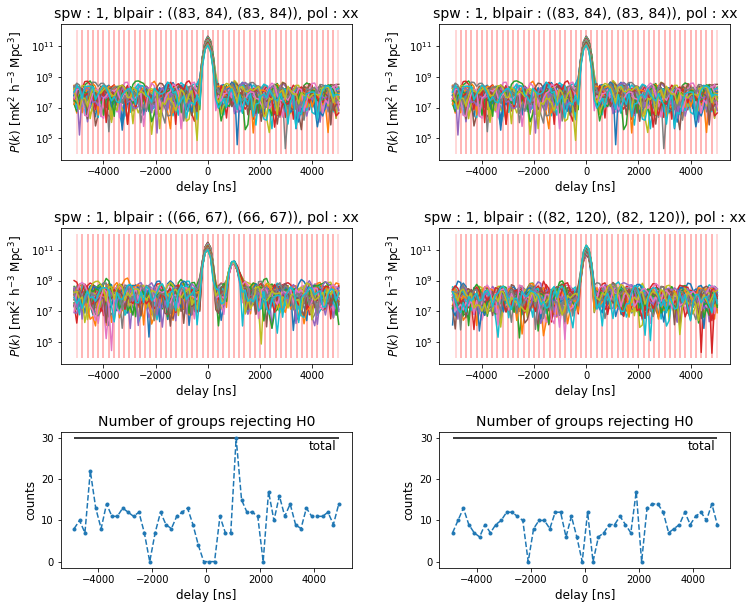

In [286]:
# Plot z-test results
plt.subplots(3, 2, sharex=True, figsize=(12, 10))
plt.subplots_adjust(hspace=.5, wspace=.3)
for i in range(6):
    pos = 321+i
    plt.subplot(pos)
    if i == 0:
        idx = 1
        plt.semilogy(dlys, power[1].T)
    elif i == 1:
        idx = 1
        plt.semilogy(dlys, power[1].T)
    elif i == 2:
        idx = 0
        plt.semilogy(dlys, power[0].T)
    elif i == 3:
        idx = 3
        plt.semilogy(dlys, power[2].T)
    elif i == 4:
        plt.plot(x, count[0], '.--')
        label_z_test()
        continue
    else:
        plt.plot(x, count[1], '.--')
        label_z_test()
        continue
    for i in range(len(lines)):
        plt.vlines(lines[i], 1e12, 1e4, 'r', alpha=0.1)
    plt.xlabel("delay [ns]", fontsize=12)
    plt.ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=12)
    plt.title("spw : {}, blpair : {}, pol : {}".format(*key[idx]), fontsize=14)

In [268]:
# null test
dly_modes = [2000, 4000] # ns
dly_idx = [(np.abs(dlys - dly_modes[0])).argmin(), (np.abs(dlys - dly_modes[1])).argmin()]

diff = {}
for i in range(2):
    power_w = power[i]
    power_wo = power[i+1]
    
    # get data in delay mode domain
    data_w = power_w[:][:,dly_idx[0]:dly_idx[1]]
    data_wo = power_wo[:][:,dly_idx[0]:dly_idx[1]]

    # subtraction
    if i == 0:
        diff[i] = - data_w.flatten() + data_wo.flatten()
    if i == 1:
        diff[i] = data_w.flatten() - data_wo.flatten()

In [269]:
# Fit the null-test results (differences) with Gaussain distribution
mu = []
std = []
for i in range(len(diff)):
    mu.append(norm.fit(diff[i])[0])
    std.append(norm.fit(diff[i])[1])

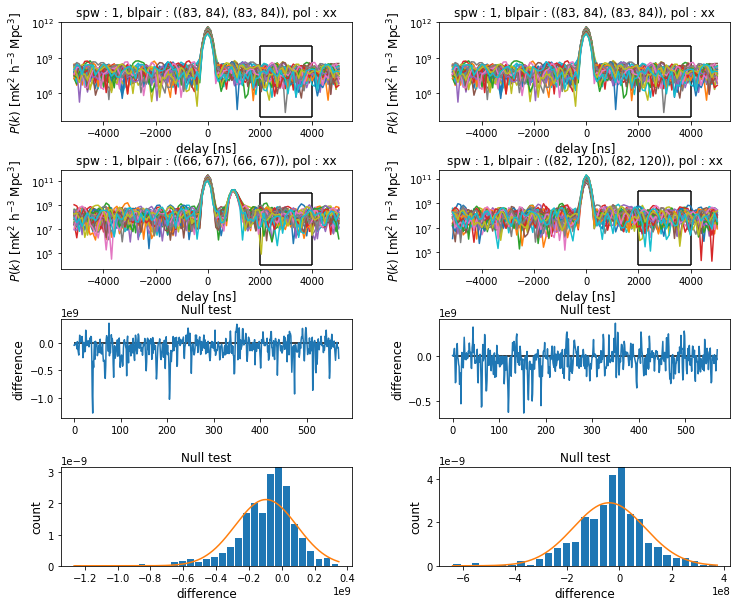

In [293]:
# Plot null-test results
norm_x = [np.linspace(min(diff[0]), max(diff[0]), 1000), np.linspace(min(diff[1]), max(diff[1]), 1000)]
x = np.linspace(0, len(diff[0])-1, len(diff[0]))
plt.subplots(4, 2, sharex=True, figsize=(12, 10))
plt.subplots_adjust(hspace=.5, wspace=.3)
for i in range(8):
    pos = 421+i
    plt.subplot(pos)
    if i == 0:
        idx = 1
        plt.semilogy(dlys, power[1].T)
    elif i == 2:
        idx = 0
        plt.semilogy(dlys, power[0].T)
    elif i == 1:
        idx = 1
        plt.semilogy(dlys, power[1].T)
    elif i == 3:
        idx = 3
        plt.semilogy(dlys, power[2].T)
    elif i == 4:
        plt.plot(x, diff[0])
        label_null_test()
        continue
    elif i == 5:
        plt.plot(x, diff[1])
        label_null_test()
        continue
    elif i == 6:
        plt.hist(diff[0], bins='auto', density=True, histtype='bar', rwidth=0.8)
        plt.plot(norm_x[0], norm.pdf(norm_x[0], loc=mu[0], scale=std[0]))
        label_null_test_hist()
        continue
    else:
        plt.hist(diff[1], bins='auto', density=True, histtype='bar', rwidth=0.8)
        plt.plot(norm_x[1], norm.pdf(norm_x[1], loc=mu[1], scale=std[1]))
        label_null_test_hist()
        continue
    # Box regions that went through the tests
    plt.vlines(2000, 1e4, 1e10)
    plt.vlines(4000, 1e4, 1e10)
    plt.hlines(1e4, 2000, 4000)
    plt.hlines(1e10, 2000, 4000)
    plt.xlabel("delay [ns]", fontsize=12)
    plt.ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=12)
    plt.title("spw : {}, blpair : {}, pol : {}".format(*key[idx]), fontsize=12)

In [294]:
# Perform AD-test to see if the null test results are randomly distributed
# get cdf of each dataset
cdf = []
for i in range(len(diff)):
    cdf.append(np.array(range(len(diff[i])))/float(len(diff[i])))

# get cdf of each fit
norm_cdf = []
for i in range(len(diff)):
    norm_cdf.append(norm.cdf(np.sort(diff[i]), mu[i], std[i]))

# perform KS test between each empirical dataset with its corresponding normal distribution
# get d (KS statistic) and p-values
d = []
p = []
for i in range(len(diff)):
    d.append(stats.ks_2samp(cdf[i], norm_cdf[i])[0])
    p.append(stats.ks_2samp(cdf[i], norm_cdf[i])[1])

a = []
for i in range(len(diff)):
    a.append(stats.anderson_ksamp([cdf[i], norm_cdf[i]])[0])
    cv = stats.anderson_ksamp([cdf[i], norm_cdf[i]])[1]

Text(0.5, 1.0, 'AD-test')

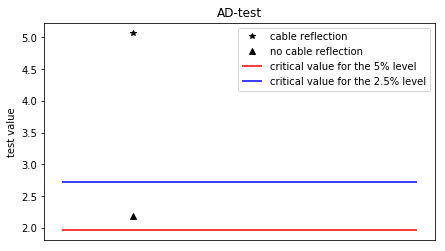

In [320]:
# Plot AD-test results
plt.figure(figsize=(7, 4))
plt.plot(2, a[0], 'k*', label='cable reflection')
plt.plot(2, a[1], 'k^', label='no cable reflection')
# plt.hlines(cv[3], 0, 10, label='2.5%')
plt.hlines(cv[2], 0, 10, 'r', label='critical value for the 5% level')
plt.hlines(cv[3], 0, 10, 'b', label='critical value for the 2.5% level')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.legend()
plt.ylabel('test value')
plt.title('AD-test')